<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

# Section 2: Creating a Baseline Model for Fake News Classification


In this notebook we'll be:
1.   Performing Feature Selection
2.   Understanding Performance Metrics



In [1]:
#@title Run this code to get started
import math
import os
import numpy as np

import pickle

import requests, io, zipfile

# Download class resources...
!wget -O data.zip 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Fake%20News%20Detection/inspirit_fake_news_resources%20(1).zip'
!unzip data.zip

basepath = '.'

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

--2023-08-05 16:31:09--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Fake%20News%20Detection/inspirit_fake_news_resources%20(1).zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 142.251.162.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109422100 (104M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 104.35M   196MB/s    in 0.5s    

2023-08-05 16:31:10 (196 MB/s) - ‘data.zip’ saved [109422100/109422100]

Archive:  data.zip
  inflating: train_val_data.pkl      
  inflating: test_data.pkl           


## Exercise 1

Below we introduce some code for taking our training and val data and producing X, y examples that can be fit by a logistic regression model. This code extracts a few basic features from the domain name extension of the website. **Your task: add features testing whether the domain name ends in ".co", ".tv", and ".news", according to the template below.**


In [2]:
def prepare_data(data, featurizer):
    X = []
    y = []
    for datapoint in data:
        url, html, label = datapoint
        # We convert all text in HTML to lowercase, so <p>Hello.</p> is mapped to
        # <p>hello</p>. This will help us later when we extract features from
        # the HTML, as we will be able to rely on the HTML being lowercase.
        html = html.lower()
        y.append(label)

        features = featurizer(url, html)

        # Gets the keys of the dictionary as descriptions, gets the values
        # as the numerical features. Don't worry about exactly what zip does!
        feature_descriptions, feature_values = zip(*features.items())

        X.append(feature_values)

    return X, y, feature_descriptions

# Returns a dictionary mapping from plaintext feature descriptions to numerical
# features for a (url, html) pair.
def domain_featurizer(url, html):
    features = {}

    # Binary features for the domain name extension.
    features['.com domain'] = url.endswith('.com')
    features['.org domain'] = url.endswith('.org')
    features['.net domain'] = url.endswith('.net')
    features['.info domain'] = url.endswith('.info')
    features['.org domain'] = url.endswith('.org')
    features['.biz domain'] = url.endswith('.biz')
    features['.ru domain'] = url.endswith('.ru')
    features['.co.uk domain'] = url.endswith('.co.uk')

    ### YOUR CODE HERE ###
    features['.co domain'] = url.endswith('.co')
    features['.tv domain'] = url.endswith('.tv')
    features['.news domain'] = url.endswith('.news')

    ### END CODE HERE ###

    return features

## Instructor-Led Discussion: Deciding Inputs to our Model

Make sure you understand what the code above is doing. It produces X, y such that X contains a list of features for each site in the dataset, and y contains the labels in corresponding order. *feature_descriptions* is a list of the names of features (.e.g., '.com domain'). This will be important later when we want to know the names of features when interpreting the model. Let's run our code for processing the data on the train and val sets from yesterday.



## Exercise 2


<b>Your task:</b>
1. Initialize your `X_train`, `y_train`, and `feature_descriptions` variables by passing `train_data` and `domain_featurizer` into the `prepare_data()` function.
2. Initialize your `X_val`, `y_val`, and `feature_descriptions` variables by passing `val_data` and `domain_featurizer` into the `prepare_data()` function.

In [4]:
with open(os.path.join(basepath, 'train_val_data.pkl'), 'rb') as f:
  train_data, val_data = pickle.load(f)

print('Number of train examples:', len(train_data))
print('Number of val examples:', len(val_data))

### YOUR CODE HERE ###
X_train, y_train, future_descripitons = prepare_data(train_data, domain_featurizer)
X_val,y_val,feature_descriptions = prepare_data(val_data, domain_featurizer)
### END CODE HERE ###

print('Number of features per example:', len(X_train[0]))
print('Feature descriptions:')
print(feature_descriptions)

Number of train examples: 2002
Number of val examples: 309
Number of features per example: 7
Feature descriptions:
('.com domain', '.org domain', '.net domain', '.info domain', '.biz domain', '.ru domain', '.co.uk domain')


Now to train on our featurized data. We'll use the `scikit-learn` library as we've done so far in the program, because it makes it easy to quickly iterate on different types of models.



## Exercise 3


Another quick exercise: load the `LogisticRegression` model from `scikit-learn` with default parameters (no arguments to the constructor). Then fit it on `X_train` and `y_train` (~5 minutes).

In [8]:
### YOUR CODE HERE ###
baseline_model= LogisticRegression()
baseline_model.fit(X_train, y_train)
### END CODE HERE ###

LogisticRegression()

## Exercise 4



In [9]:
y_train_pred = baseline_model.predict(X_train)
print('Train accuracy', accuracy_score(y_train, y_train_pred))

Train accuracy 0.6108891108891109


We can see that we are not doing very well, but we are doing better than 50%. We can do the same for the val data to see how we are doing on unseen data, which is more valuable for us if we want to make predictions on new websites. Fill in the code below to evaluate val accuracy!

In [10]:
### YOUR CODE HERE ###
y_val_pred=baseline_model.predict(X_val)
### END CODE HERE ###
print('Val accuracy', accuracy_score(y_val, y_val_pred))

Val accuracy 0.5533980582524272


We appear to be doing a bit worse on the val data, not much better than chance. To better understand the performance of our binary classification model, we should seek to better understand the mistakes that it is making. Specifically, when our model makes a mistake (about 40% of the time), are these mistakes false negatives or false positives?

## Confusion Matrix

To answer these questions, we produce and analyze the confusion matrix. The confusion matrix is a matrix that shows the following:

![Confusion Matrix](https://miro.medium.com/max/860/1*7EcPtd8DXu1ObPnZSukIdQ.png)

where the terms mean

* TN (True Negative) = You predicted negative (real in our case, since real has a label of 0) and it’s true.
* FP (False Positive) = You predicted positive and it’s false.
* TP (True Positive) = You predicted positive (fake in our case, since fake has a label of 1) and it’s true.
* FN (False Negative) = You predicted negative and it’s false.


###Common Metrics

From the confusion matrix, we can extract commonly used metrics like precision (TP/(TP + FP)) and recall (TP/(TP + FN)).

* Precision quantifies how often the things we classify as positive are actually positive. For our task, this measures what fraction of the sites we classify as fake are actually fake.
* Recall quantifies what fraction of actually positive examples we classify as positive. In our case, this is the fraction of fake news websites that we actually identify as fake.

Finally, a useful score to summarize both precision and recall is the F-1 score. This is just a simple function (the harmonic mean) of precision and recall, shown in the summary below:

<img src="https://datascience103579984.files.wordpress.com/2019/04/capture3-24.png" width="400" height="200"></img>

##Exercise 5 |  Using the Confusion Matrix

Next, let's evaluate the performance of our model. We can visualize statistics on the number of correct and incorrect predictions using a confusion matrix.

Text(0.5, 427.9555555555555, 'Predicted Labels')

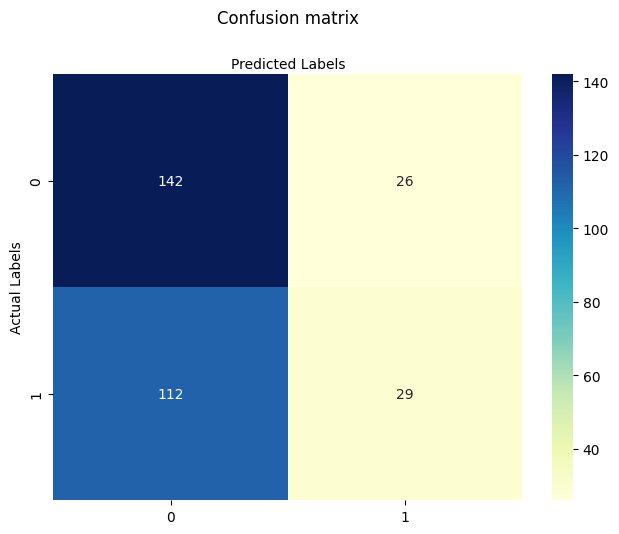

In [11]:
#@title Run this code to create the confusion matrix. { display-mode: "form" }
#@markdown If you are curious how it works you may double-click to inspect the code.

# Import the metrics class
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_val, y_val_pred)

# Visualizing the Confusion Matrix
class_names = [0,1] # Our diagnosis categories

fig, ax = plt.subplots()
# Setting up and visualizing the plot (do not worry about the code below!)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') # Creating heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

In [18]:
false_positive=cnf_matrix[0][1]
false_negative=cnf_matrix[1][0]
true_positive=cnf_matrix[0][0]
true_negative=cnf_matrix[1][1]
error_rate=(false_positive+false_negative)/(true_positive+false_positive+false_negative+true_negative)
print(error_rate)

0.44660194174757284


A Confusion Matrix can quickly tell you how well your model is doing. The primary way to figure this out is to calculate the Error Rate.

The Error Rate is:   (FP) + (FN)) / (TP + FP + FN + TN).

This is just all the false predictions (False Negative + False Positive) divided by all the predictions added together.

Use the Confusion Matrix we just created to calculate the Error Rate for our model.

## Exercise 6

In [12]:
print(y_val_pred)

[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0]


We can see that we have many false negatives, and not as many false positives. Why is this the case? If we print out `y_val_pred`, we can see that our model is mostly predicting 0's (websites are real).

What fraction of predictions in `y_val_pred` are 1's? Hint: you may find `np.mean` useful.

In [19]:
### YOUR CODE HERE ###
np.mean(y_val_pred)
print(np.mean(y_val_pred))
### END CODE HERE ###

0.1779935275080906


Why so many 0's? The only information we are giving our model is its domain name extension. It's natural that the model would learn that websites with ".biz" extensions are unlikely to be reliable news websites, but it is still the case that most websites in the dataset (fake and real) have ".com" extensions. Thus, our model will misclassify many fake news websites with ".com" extensions as real.

In [20]:
prf = precision_recall_fscore_support(y_val, y_val_pred)

print('Precision:', prf[0][1])
print('Recall:', prf[1][1])
print('F-Score:', prf[2][1])

Precision: 0.5272727272727272
Recall: 0.20567375886524822
F-Score: 0.29591836734693877


Again, the precision and recall metrics suggest that when we classify a website as fake, we are usually right, but we are not doing great at classifying these websites as fake frequently enough.

##Using Keywords for a Stronger Baseline

The key problem with our model in its current state is that it simply does not have enough information. This should not be a surprise–it was pretty unlikely in the first place that domain name extensions would be enough. If you like, feel free to add a few more extensions in the “featurizer” above and re-run all the code for evaluation–you'll find it doesn't make much of a difference.
Where can we get more information about webpages? From the HTML! Remember that the HTML contains all of the text and structure of a webpage. If we cleverly choose features from the HTML to feed into our logistic regression model, we will drastically improve our performance. We saw yesterday that probing hypotheses related to the counts of hypotheses words produced interesting results, and we will continue in this direction today to produce a model that leverages these differences in word frequencies.


## Exercise 7: Instructor-Led Discussion on Better Input Features



The below code introduces a better featurizer that counts the number of keywords (normalized using the *log* function) in the HTML. Normalizing the counts is a trick that prevents the featurized values from becoming too extreme. Read the code and make sure you understand what it is doing. Then add "sports" and "finance" as additional keywords to expand our model.

**Run the below code and discuss what it is doing as a class. Add in additional keywords to further expand our model as you see fit.**





In [32]:
# Gets the log count of a phrase/keyword in HTML (transforming the phrase/keyword
# to lowercase).
def get_normalized_count(html, phrase):
    return math.log(1 + html.count(phrase.lower()))

# Returns a dictionary mapping from plaintext feature descriptions to numerical
# features for a (url, html) pair.
def keyword_featurizer(url, html):
    features = {}

    # Same as before.
    features['.com domain'] = url.endswith('.com')
    features['.org domain'] = url.endswith('.org')
    features['.net domain'] = url.endswith('.net')
    features['.info domain'] = url.endswith('.info')
    features['.org domain'] = url.endswith('.org')
    features['.biz domain'] = url.endswith('.biz')
    features['.ru domain'] = url.endswith('.ru')
    features['.co.uk domain'] = url.endswith('.co.uk')
    features['.co domain'] = url.endswith('.co')
    features['.tv domain'] = url.endswith('.tv')
    features['.news domain'] = url.endswith('.news')
    features['.nl domain'] = url.endswith('.nl')
    features['.xyz domain'] = url.endswith('.xyz')

    ### YOUR CODE HERE ###
    keywords = ["sports","fitness","Biden","Trump","court","Worldcup","Forest fires",""]
    ### END CODE HERE

    for keyword in keywords:
      features[keyword + ' keyword'] = get_normalized_count(html, keyword)

    return features

##Exercise 8



Let's run and evaluate the above featurizer. Add in code to fit the model, compute train accuracy, val accuracy, val confusion matrix, and val precision, recall, and F1-Score, just as before.

In [33]:
X_train, y_train, feature_descriptions = prepare_data(train_data, keyword_featurizer)
X_val, y_val, feature_descriptions = prepare_data(val_data, keyword_featurizer)

print('Number of features per example:', len(X_train[0]))
print('Feature descriptions:')
print(feature_descriptions)
print()

baseline_model = LogisticRegression()

### YOUR CODE HERE ###
baseline_model.fit(X_train,y_train)
y_tain_pred=baseline_model.predict(X_train)
y_val_pred=baseline_model.predict(X_val)
val_accuracy=accuracy_score(y_val, y_val_pred)
train_accuracy =accuracy_score(y_train,y_train_pred)
cnf_matrix = metrics.confusion_matrix(y_val, y_val_pred)
prf = precision_recall_fscore_support(y_val, y_val_pred)
print("train_accuracy:", train_accuracy)
print("val_accuracy:", val_accuracy)
print('Precision:', prf[0][1])
print('Recall:', prf[1][1])
print('F-Score:', prf[2][1])
### END CODE HERE ###

Number of features per example: 20
Feature descriptions:
('.com domain', '.org domain', '.net domain', '.info domain', '.biz domain', '.ru domain', '.co.uk domain', '.co domain', '.tv domain', '.news domain', '.nl domain', '.xyz domain', 'sports keyword', 'fitness keyword', 'Biden keyword', 'Trump keyword', 'court keyword', 'Worldcup keyword', 'Forest fires keyword', ' keyword')

train_accuracy: 0.6108891108891109
val_accuracy: 0.7216828478964401
Precision: 0.6470588235294118
Recall: 0.8581560283687943
F-Score: 0.7378048780487805


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can see that we are doing dramatically better! The next section addresses how to know which of the above added features made the difference in improving the model.

## Interpreting our Model



### Instructor-Led Discussion: Interpreting Input Variables

As mentioned earlier, a key motivation for using a simpler model is interpretability.

We've learned that the prediction of a logistic regression classifier is just the output of a multiplication with model weights, followed by a non-linear transformation (sigmoid). Because the sigmoid function is always increasing (monotonic) on its domain (see below), we know that if the dot product (or multiplication of vectors) between model weights and input features is large, then the output prediction will be closer to 1. If the dot product is small, then the output prediction will be closer to 0.

![Sigmoid](https://cdn-images-1.medium.com/max/2400/1*RqXFpiNGwdiKBWyLJc_E7g.png)

Thus, the weights corresponding to features tell us whether the features are important in the classification. If the weight corresponding to the feature ".net domain" has a large positive value, then websites with ".net" domains are more likely to be classified as fake (since fake has label 1). If it has a large negative value, then these websites are more likely to be classified as real. If it has value close to 0, then the feature may not be useful (at least, it may not be useful given that the other features are present).


###Using Feature Descriptions

Let's see what weights our model learned. The code below uses *feature_descriptions* and the weights, or coefficients, of the model and sorts them in ascending order.

In [34]:
sorted(zip(feature_descriptions, baseline_model.coef_[0].tolist()), key=lambda x: x[1])

[('sports keyword', -0.7756937562807644),
 ('Worldcup keyword', -0.3265411891772274),
 ('court keyword', -0.2313496794731637),
 (' keyword', -0.16264378326223952),
 ('fitness keyword', -0.021792877646218223),
 ('Trump keyword', -0.013332028923795827),
 ('Biden keyword', -0.012381460820370407),
 ('.com domain', -0.011316278464548307),
 ('.nl domain', 0.0),
 ('.xyz domain', 0.0),
 ('.biz domain', 0.23986052173191377),
 ('.org domain', 0.6307034426197901),
 ('.ru domain', 0.9431317020979458),
 ('.tv domain', 1.0781007202692041),
 ('.news domain', 1.1486265576738781),
 ('.co.uk domain', 1.5509452831374855),
 ('.info domain', 1.679155844465373),
 ('.net domain', 2.4578511296013956),
 ('.co domain', 2.638250498570926),
 ('Forest fires keyword', 2.7579170068691075)]

## Exercise 9

Answer the following questions:

* What features have positive weight (most predictive of being fake)? What does that indicate?
* Which ones have negative weight (most predictive of being real)? What does that indicate?
* Which ones have close to 0 weight?
* Are there any feature weights that surprise you?
* Try coming up with explanations for why the feature weights are the way they are. Does this help you come up with new feature ideas? (~15 minutes)

In [ ]:
'''
YOUR ANSWERS TO QUESTIONS HERE
'''

## Instructor-Led Discussion: Final Interpretation of Inputs

##Exercise 10 |  Final Baseline

Finally, play around with the last few cells, adding more keywords and domain names to see how the results change. Note that "keywords" can be a variety of things: English words, English phrases (spaces are allowed), HTML tags, and any other string present in HTML. Also notice how the weights on different features vary–you may observe some interesting effects. When you are done, run the cell below to run evaluations again!

In [35]:
y_train_pred = baseline_model.predict(X_train)
print('Train accuracy', accuracy_score(y_train, y_train_pred))

y_val_pred = baseline_model.predict(X_val)
print('Val accuracy', accuracy_score(y_val, y_val_pred))

prf = precision_recall_fscore_support(y_val, y_val_pred)

print('Precision:', prf[0][1])
print('Recall:', prf[1][1])
print('F-Score:', prf[2][1])

Train accuracy 0.7872127872127872
Val accuracy 0.7216828478964401
Precision: 0.6470588235294118
Recall: 0.8581560283687943
F-Score: 0.7378048780487805


Text(0.5, 427.9555555555555, 'Predicted Labels')

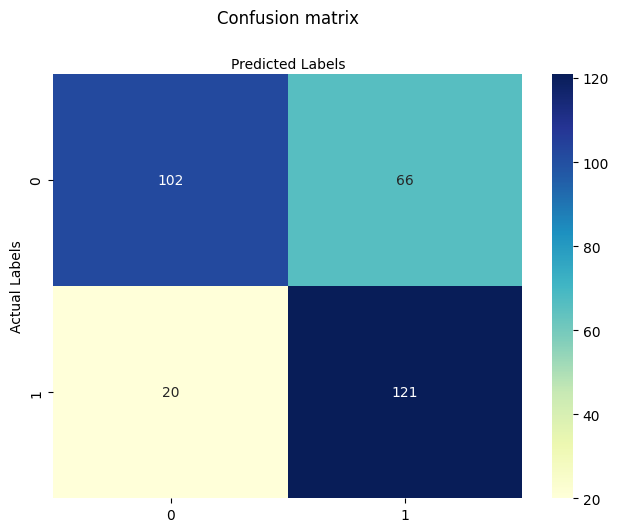

In [36]:
#@title Run this cell to create the confusion matrix. { display-mode: "form" }
# Create the Confusion Matrix
cnf_mat_2 = confusion_matrix(y_val, y_val_pred)

# Visualizing the Confusion Matrix
class_names = [0,1] # Our diagnosis categories

fig, ax = plt.subplots()
# Setting up and visualizing the plot (do not worry about the code below!)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_mat_2), annot=True, cmap="YlGnBu" ,fmt='g') # Creating heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

Congratulations on completing this notebook! Looking at the results of our final baseline, you may be surprised this approach is working at all–after all, our model is still barely looking at the content of websites. We will further explore the issue of modeling the content of websites tomorrow, but as a result of our efforts today, we now know that we can make progress with a relatively simple approach!